In [45]:
import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
torch.random.seed = 42

import numpy as np

import random
import gc
import os

import matplotlib.pyplot as plt
%matplotlib inline

# Configs

In [3]:
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
n_epochs = 3
log_interval = 10

In [46]:
data_dir = os.path.abspath(os.path.relpath('../data'))
image_dir = os.path.abspath(os.path.relpath('../doc/images'))

# Load dataset

In [4]:
mnist_trainset = datasets.MNIST(root='../data', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Resize(32),
                                    torchvision.transforms.ToTensor(), 
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])
                                )

mnist_testset = datasets.MNIST(root='../data', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Resize(32),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                                                    ])
                              )

In [5]:
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size_train, True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size_test, True)

In [6]:
torch.utils.data.Subset(train_loader, [1, 2, 3]).dataset

In [7]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

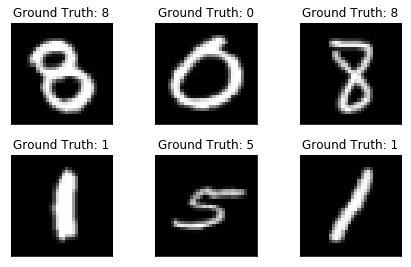

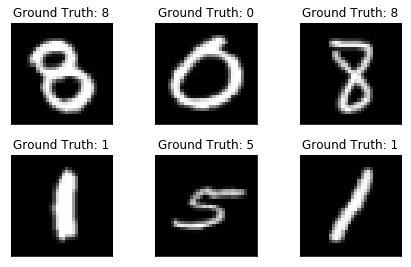

In [8]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

# Helper functions

In [9]:
def train(epoch, net, optimizer, train_loader, v=1, track=0):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if (v > 0) and (batch_idx % log_interval == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        if track > 0:
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
#         torch.save(network.state_dict(), 'model.pth')
#         torch.save(optimizer.state_dict(), 'optimizer.pth')

In [30]:
def test(net, optimizer, test_loader, v=1, track=0):
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    if track > 0:
        test_losses.append(test_loss)
    if v>0:
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct.item()/len(test_loader.dataset)

In [42]:
def kfold(k, N, epochs, model, optimizer, state_dict, train_loader):
    loss_avg = 0
    acc_avg = 0
    for i in range(k):
        model.load_state_dict(state_dict)
        epoch = 0
        count = 0
        min_error = 100
        max_acc = 1
        train_mask = []
        val_mask = []
        for i in range(60000):
            if i%k == 0:
                val_mask.append(i)
            else:
                train_mask.append(i)
        X_train = torch.utils.data.Subset(train_loader.dataset, train_mask)
        X_val = torch.utils.data.Subset(train_loader.dataset, val_mask)
        X_train_l = torch.utils.data.DataLoader(X_train, batch_size_train, True)
        X_val_l = torch.utils.data.DataLoader(X_val, batch_size_test, True)
        while (epoch < epochs and count < 1):
            train(epoch, model, optimizer, X_train_l, 0)
            test_loss, test_acc = test(model, optimizer, X_val_l, 0)
            epoch += 1
            if test_loss >= min_error:
                count += 1
            else:
                min_error = test_loss
                max_acc = test_acc
            print('{:.4f} - '.format(test_loss), end='')
        loss_avg += min_error
        acc_avg += max_acc
        print('{:.4f} ({:4.2f}%) |'.format(min_error, 100*max_acc), end='')
    print('>')
    return loss_avg/k, acc_avg/k

# Architectures

## MLP

In [36]:
class MLP(nn.Module):
    """MLP with 3 ReLU hidden layers and 1 softmax output layer"""
    
    def __init__(self, H, D):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H)
        self.fc4 = nn.Linear(H, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(D)
        
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = self.dropout(x)
        x = self.relu(self.fc1(x)) # H
        x = self.dropout(x)
        x = self.relu(self.fc2(x)) # H
        x = self.dropout(x)
        x = self.relu(self.fc3(x)) # H
        x = self.dropout(x)
        x = F.log_softmax(self.fc4(x)) # 10
        return x

## CNN

In [37]:
class CNN(nn.Module):
    """CNN inspired in LeNet 5"""
    def __init__(self, D):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(D)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # 6 @ 14x14
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) # 16 @ 5x5
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) # 120
        x = self.dropout(x)
        x = F.relu(self.fc2(x)) # 84
        x = self.dropout(x)
        x = self.fc3(x)         # 10
        return F.log_softmax(x)

# MLP

In [40]:
models = []
for H in [30, 60, 100, 300, 600]:
    for D in [0, 0.3, 0.5]:
        model = MLP(H, D)
        copy = MLP(H, D)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        print('D =', D, 'H =', H)
        loss, acc = kfold(3, 60000, 3, model, optimizer, copy.state_dict(), train_loader)
        print()
        models.append((H, D, loss, acc)) 

D = 0 H = 30


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.2480 - 0.3674 - 0.2528 - 0.2480 (93.30%) |0.3001 - 0.3029 - 0.2684 - 0.2684 (92.69%) |0.3742 - 0.2763 - 0.2797 - 0.2763 (92.59%) |>

D = 0.3 H = 30
0.8573 - 0.8281 - 0.7512 - 0.7512 (70.77%) |0.6286 - 0.5859 - 0.5992 - 0.5859 (86.75%) |0.5841 - 0.4908 - 0.5583 - 0.4908 (87.34%) |>

D = 0.5 H = 30
1.2072 - 1.1957 - 1.1159 - 1.1159 (57.49%) |1.4715 - 1.3362 - 1.3740 - 1.3362 (48.39%) |1.3453 - 1.3006 - 1.2712 - 1.2712 (59.64%) |>

D = 0 H = 60
0.2498 - 0.2699 - 0.2424 - 0.2424 (93.55%) |0.2932 - 0.2505 - 0.2378 - 0.2378 (93.53%) |0.2875 - 0.2768 - 0.2647 - 0.2647 (93.13%) |>

D = 0.3 H = 60
0.4399 - 0.3862 - 0.4690 - 0.3862 (89.23%) |0.4759 - 0.4446 - 0.4960 - 0.4446 (88.44%) |0.6309 - 0.5389 - 0.5428 - 0.5389 (86.52%) |>

D = 0.5 H = 60
0.8863 - 0.8899 - 0.8700 - 0.8700 (71.70%) |1.4791 - 1.4425 - 1.3866 - 1.3866 (51.40%) |1.2612 - 1.3452 - 1.2707 - 1.2612 (59.86%) |>

D = 0 H = 100
0.2852 - 0.2464 - 0.2117 - 0.2117 (94.58%) |0.2760 - 0.2651 - 0.2397 - 0.2397 (93.52%) |0.2701 - 0.2653

In [41]:
models

[(30, 0, 0.2641982721964518, 0.30711666666666665),
 (30, 0.3, 0.6092724721272786, 0.2902166666666667),
 (30, 0.5, 1.241109981282552, 0.1988),
 (60, 0, 0.24828392003377275, 0.31043333333333334),
 (60, 0.3, 0.456561171468099, 0.2912),
 (60, 0.5, 1.1726163126627605, 0.17521666666666666),
 (100, 0, 0.2213017837524414, 0.31516666666666665),
 (100, 0.3, 0.4845912231445313, 0.26666666666666666),
 (100, 0.5, 0.9437252817789714, 0.21486666666666665),
 (300, 0, 0.2592176300048828, 0.3068),
 (300, 0.3, 1.7087612360636395, 0.0373),
 (300, 0.5, 1.8020073730468749, 0.0373),
 (600, 0, 1.1112127822875977, 0.23518333333333333),
 (600, 0.3, 1.720319202677409, 0.0373),
 (600, 0.5, 2.009753505452474, 0.0325)]

In [43]:
n_epochs = 5
mlp = MLP(300, 0)
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [44]:
test(mlp, optimizer, test_loader, v=1, track=1)
for epoch in range(1, n_epochs + 1):
    train(epoch, mlp, optimizer, train_loader, v=1, track=1)
    test(mlp, optimizer, test_loader, v=1, track=1)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3033, Accuracy: 779/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304337
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.896874
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.903053
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.398313
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.788401
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.565434
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.340337
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.860425
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.409150
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.492525
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.533781
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.599849
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.287572
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.552868
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.489740
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.262854
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.205324
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.182044
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.676742
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.177863
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.059307
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.511493
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.126026
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.202601
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.158159
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.137326
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.228382
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.133361
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.451703
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.151333
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.342411
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.111125
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.516053
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.115475
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.170090
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.367243
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.214245
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.163403
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.220661


Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.336187
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.299375
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.119195
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.246706
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.126304
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.139876
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.291939
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.343605
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.109152
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.099491
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.100336
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.247319
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.433290
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.190070
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.199004
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.231056
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.046282
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.331394
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.160551
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.087970


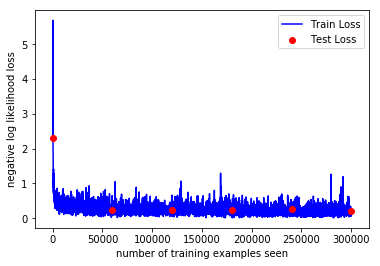

In [47]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue', zorder=1)
plt.scatter(test_counter, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.savefig(os.path.join(image_dir, 'mlp.png'), bbox_inches='tight')
plt.show()

# CNN

In [48]:
models_cnn = []
for D in [0, 0.3, 0.5]:
    model = CNN(D)
    copy = CNN(D)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print('D =', D)
    loss, acc = kfold(3, 60000, 3, model, optimizer, copy.state_dict(), train_loader)
    print()
    models_cnn.append((D, loss, acc)) 

D = 0


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0.1021 - 0.0998 - 0.1296 - 0.0998 (97.32%) |0.1146 - 0.1282 - 0.1146 (96.89%) |0.1306 - 0.1178 - 0.1295 - 0.1178 (96.86%) |>

D = 0.3
0.1084 - 0.1028 - 0.1167 - 0.1028 (97.15%) |0.1621 - 0.1543 - 0.1296 - 0.1296 (96.26%) |0.1561 - 0.1432 - 0.1431 - 0.1431 (96.54%) |>

D = 0.5
0.1326 - 0.1507 - 0.1326 (96.65%) |0.1824 - 0.1526 - 0.1192 - 0.1192 (96.81%) |0.1828 - 0.1549 - 0.1696 - 0.1549 (96.16%) |>



In [49]:
models_cnn

[(0, 0.11073824183146158, 0.97025),
 (0.3, 0.12515435740152994, 0.9664999999999999),
 (0.5, 0.13555918986002605, 0.9654166666666667)]

In [53]:
cnn = CNN(0)
n_epochs = 5
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [54]:
test(cnn, optimizer, test_loader, v=1, track=1)
for epoch in range(1, n_epochs + 1):
    train(epoch, cnn, optimizer, train_loader, v=1, track=1)
    test(cnn, optimizer, test_loader, v=1, track=1)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3064, Accuracy: 945/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323610
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.246524
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.000304
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.354013
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.496763
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.470210
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.361845
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.258462
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.230211
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.251411
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.528795
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.245871
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.195322
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.085947
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.220837
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.075636
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.299431
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.299793
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.039068
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.261243
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.285498
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.308510
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.004128
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.117195
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.152593
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.023223
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.256018
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.172182
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.187270
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.157483
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.157134
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.043630
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.030093
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.150986
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.015598
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.070826
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.054534
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.161740
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.083560


Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.006278
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.080105
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.191852
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.034667
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.087444
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.024873
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.075141
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.040082
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.065995
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.132581
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.136405
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.071172
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.024011
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.010495
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.078449
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.095261
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.051359
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.251711
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.078338
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.014508


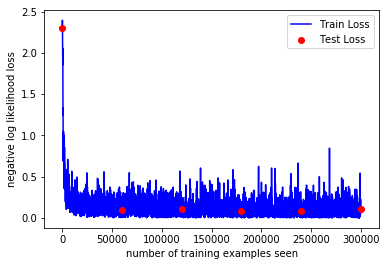

In [55]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue', zorder=1)
plt.scatter(test_counter, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.savefig(os.path.join(image_dir, 'cnn.png'), bbox_inches='tight')
plt.show()